In [1]:
import openmc
import openmc_geometry_plot  # adds extra plotting functions to openmc.Geometry object\n",
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import openmc_source_plotter
from math import pi, sin, cos, sqrt

In [2]:
air = openmc.Material(name="Air")
air.set_density("g/cc", 0.001205)
air.add_element("N", 0.784431)
air.add_element("O", 0.210748)
air.add_element("Ar", 0.0046)

concrete = openmc.Material(name="concrete")
concrete.set_density("g/cm3", 2.251)
concrete.add_element("H", 0.0033)
concrete.add_element("O", 0.4958)
concrete.add_element("Na", 0.0148)
concrete.add_element("Mg", 0.0061)
concrete.add_element("Al", 0.0457)
concrete.add_element("Si", 0.3355)
concrete.add_element("P", 0.0003)
concrete.add_element("S", 0.0015)
concrete.add_element("Cl", 0.0001)
concrete.add_element("K", 0.0189)
concrete.add_element("Ca", 0.0637)
concrete.add_element("Ti", 0.0009)
concrete.add_element("Mn", 0.0002)
concrete.add_element("Fe", 0.0131)

steel = openmc.Material(name="steel")
steel.set_density("g/cm3", 7.8)
steel.add_element("Fe", 0.97)
steel.add_element("C", 0.03)

materials = openmc.Materials([air, concrete, steel])
materials.export_to_xml()


In [3]:
concrete_inner_dim = 2000  # outer radius of the cylinder in cm
concrete_outer_dim = 2100
cylinder_height = 4600
bottom_concrete = -100

# Create cells representing the components
concrete_outer = openmc.ZCylinder(r=2100)
concrete_inner = openmc.ZCylinder(r=2000)
boundary_outer = openmc.ZCylinder(r=2400, boundary_type="vacuum")

zplane_1 = openmc.ZPlane(z0=bottom_concrete)
zplane_3 = openmc.ZPlane(z0=0)
zplane_4 = openmc.ZPlane(z0=cylinder_height)
zplane_5 = openmc.ZPlane(z0=6580)
zplane_6 = openmc.ZPlane(z0=6700)
zplane_7 = openmc.ZPlane(z0=7000, boundary_type="vacuum")
zplane_8 = openmc.ZPlane(z0=-420, boundary_type="vacuum")

concrete_inner_sphere = openmc.Sphere(r=concrete_inner_dim, z0=cylinder_height)
concrete_outer_sphere = openmc.Sphere(r=concrete_outer_dim, z0=cylinder_height)
boundary_top = openmc.Sphere(r=2400, z0=cylinder_height, boundary_type="vacuum")

boundary_bottom = -concrete_outer & +zplane_8 & -zplane_1
boundary_mid = -boundary_outer & +concrete_outer  & +zplane_8 & -zplane_4
boundary_top = -boundary_top & +concrete_outer_sphere & +zplane_4 & -zplane_7

concrete_cylinder_region = +concrete_inner & -concrete_outer  & +zplane_3 & -zplane_4
concrete_sphere_region = +concrete_inner_sphere & -concrete_outer_sphere & +zplane_4 & -zplane_6 

bottom_concrete_region = -concrete_outer & +zplane_1 & -zplane_3

room_region = -concrete_inner & +zplane_3 & -zplane_4
room_dome_region = +zplane_4 & - concrete_inner_sphere 

column_cells=[]
r_inner=2006
r_outer=2094
radii = [r_inner, r_outer]
num_in_rings = [573, 598]
center_point = (0, 0)
radius = 2.82
for index in range(len(num_in_rings)):
    elem_num = num_in_rings[index]
    ring_radius = radii[index]
    angle_step = 2*pi/ elem_num
    for i in range(elem_num):
        angle =  i * angle_step
        x_position =  ring_radius *cos(angle)
        y_position =  ring_radius *sin(angle)
        column_shape = openmc.ZCylinder(r=radius, x0=x_position, y0=y_position)
        column_shape_region = -column_shape & +zplane_3 & -zplane_4

        concrete_cylinder_region &= ~column_shape_region
        column_cells.append(openmc.Cell(region=column_shape_region, fill=steel))


In [4]:
ring_inner = openmc.ZCylinder(r=2010)
ring_inner_thickness = openmc.ZCylinder(r=2015.64)
ring_outer = openmc.ZCylinder(r=2090)
ring_outer_thickness = openmc.ZCylinder(r=2084.36)

spacing = 22
num_rings = round(cylinder_height / spacing)

for i in range(num_rings):
    plane_height_1 = spacing * i - radius
    plane_height_2 = spacing * i + radius
    zplane_height_1 = openmc.ZPlane(z0=plane_height_1)
    zplane_height_2 = openmc.ZPlane(z0=plane_height_2)
    inner_ring_region = +ring_inner & -ring_inner_thickness & +zplane_height_1 & -zplane_height_2
    outer_ring_region = +ring_outer_thickness & -ring_outer & +zplane_height_1 & -zplane_height_2
    concrete_cylinder_region &= ~inner_ring_region
    concrete_cylinder_region &= ~outer_ring_region
    column_cells.append(openmc.Cell(region=inner_ring_region, fill=steel))
    column_cells.append(openmc.Cell(region=outer_ring_region, fill=steel))
    
column_universe = openmc.Universe(cells=column_cells)


In [5]:
#column_universe.plot(width=(5000, 5000), basis='xy')

In [6]:
concrete_cylinder_cell = openmc.Cell(region=concrete_cylinder_region, fill=concrete, name="concrete_cylinder_cell")
concrete_sphere_cell = openmc.Cell(region=concrete_sphere_region, fill=concrete, name="concrete_sphere_cell")
bottom_concrete_cell = openmc.Cell(region=bottom_concrete_region, fill=concrete, name="bottom_concrete_cell")
room_cell = openmc.Cell(region=room_region, fill=air, name="room_cell")
room_dome_cell = openmc.Cell(region=room_dome_region, fill=air, name="room_dome_cell")
boundary_bottom_cell = openmc.Cell(region=boundary_bottom, fill=air, name="boundary_bottom_cell")
boundary_mid_cell = openmc.Cell(region=boundary_mid, fill=air, name="boundary_mid_cell")
boundary_top_cell = openmc.Cell(region=boundary_top, fill=air, name="boundary_top_cell")

root_universe = openmc.Universe(name="root_universe")
root_universe.add_cells([
    concrete_cylinder_cell,
    concrete_sphere_cell,
    bottom_concrete_cell,
    room_cell,
    room_dome_cell,
    boundary_bottom_cell,
    boundary_mid_cell,
    boundary_top_cell,
])

column_universe_cell = openmc.Cell(fill=column_universe)
root_universe.add_cells([column_universe_cell])

geometry = openmc.Geometry(root_universe)

geometry.export_to_xml()

In [7]:
model = openmc.Model()
model.geometry = geometry

/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)


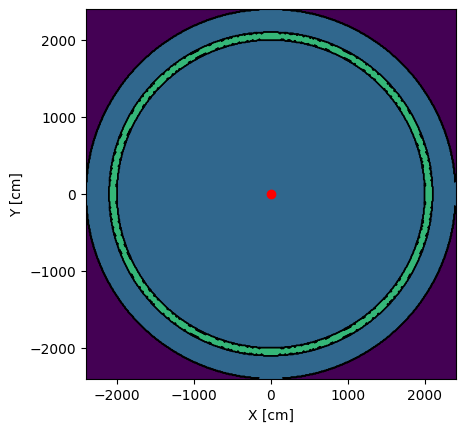

In [8]:
# location of the point source
source_x = 0
source_y = 0
source_z = 1250

xlabel, ylabel = geometry.get_axis_labels(view_direction="z")
plt.xlabel(xlabel)
plt.ylabel(ylabel)

plot_extent = geometry.get_mpl_plot_extent(view_direction="z")

data_slice = geometry.get_slice_of_material_ids(view_direction="z")
# plots the materials with randomly assigned colors
plt.imshow(
    np.fliplr(data_slice),
    extent=plot_extent,
)

# plots the outline of the cells
plt.contour(
    np.fliplr(data_slice),
    origin="upper",
    colors="k",
    linestyles="solid",
    linewidths=1,
    extent=plot_extent,
)

# plots the source location
plt.scatter(source_x, source_y, c="red")
plt.savefig('geometry_view.svg')


/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another PlotBase instance already exists with id=42.
  warn(msg, IDWarning)


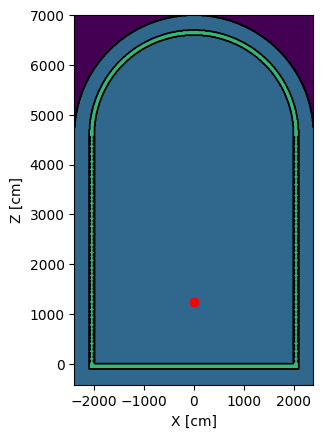

In [9]:
plt.clf()
plt.cla()

xlabel, ylabel = geometry.get_axis_labels(view_direction="y")
plt.xlabel(xlabel)
plt.ylabel(ylabel)

plot_extent = geometry.get_mpl_plot_extent(view_direction="y")

data_slice = geometry.get_slice_of_material_ids(view_direction="y")
# plots the materials with randomly assigned colors
plt.imshow(
    np.fliplr(data_slice),
    extent=plot_extent,
)
# plots the outline of the cells
plt.contour(
    np.fliplr(data_slice),
    origin="upper",
    colors="k",
    linestyles="solid",
    linewidths=1,  
    extent=plot_extent,
)

# plots the source location
plt.scatter(source_x, source_z, c="red")
plt.savefig('geometry_view_2.svg')


/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another PlotBase instance already exists with id=42.
  warn(msg, IDWarning)


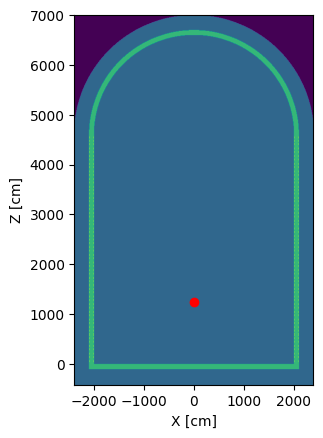

In [10]:
plt.clf()
plt.cla()

xlabel, ylabel = geometry.get_axis_labels(view_direction="y")
plt.xlabel(xlabel)
plt.ylabel(ylabel)

plot_extent = geometry.get_mpl_plot_extent(view_direction="y")

data_slice = geometry.get_slice_of_material_ids(view_direction="y")
# plots the materials with randomly assigned colors
plt.imshow(
    np.fliplr(data_slice),
    extent=plot_extent,
)
# plots the source location
plt.scatter(source_x, source_z, c="red")
plt.savefig('geometry_full_view_y.svg')


In [11]:
mesh = openmc.RegularMesh().from_domain(geometry)
mesh.dimension = (100, 100, 1)

mesh_filter = openmc.MeshFilter(mesh)

flux_tally = openmc.Tally(name="flux tally")
flux_tally.filters = [mesh_filter]
flux_tally.scores = ["flux"]

model.tallies = [flux_tally]

space = openmc.stats.Point((source_x, source_y, source_z))
angle = openmc.stats.Isotropic()
energy = openmc.stats.Discrete(20e+6, 1)
#energy = openmc.stats.Discrete(2e+6, 1)

source = openmc.Source(space=space, angle=angle, energy=energy)
source.particle = "photon"
#source.particle = "neutron"
model.settings.run_mode = "fixed source"
model.settings.source = source
model.settings.particles = 2500
model.settings.batches = 5


/opt/venv/lib/python3.11/site-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another PlotBase instance already exists with id=42.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another PlotBase instance already exists with id=42.
  warn(msg, IDWarning)


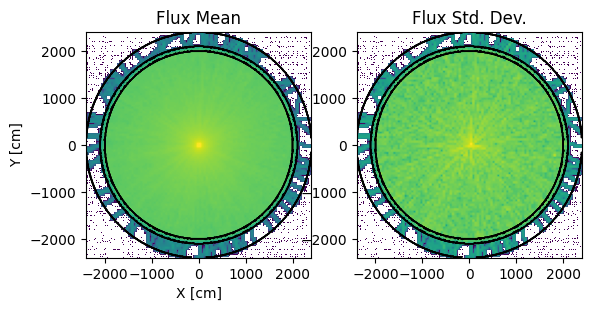

In [12]:
def run_and_plot(model, filename, output=True):

    sp_filename = model.run(output=output)

    with openmc.StatePoint(sp_filename) as sp:
        flux_tally = sp.get_tally(name="flux tally")

    llc, urc = model.geometry.bounding_box

    # create a plot of the mean flux values
    flux_mean = flux_tally.mean.reshape(100, 100)
    plt.subplot(1, 2, 1)
    plt.imshow(
        flux_mean,
        origin="lower",
        extent=(llc[0], urc[0], llc[1], urc[1]),
        norm=LogNorm(),
    )
    plt.title("Flux Mean")

    plot_extent = geometry.get_mpl_plot_extent(view_direction="z")
    data_slice = geometry.get_slice_of_material_ids(view_direction="z")
    xlabel, ylabel = geometry.get_axis_labels(view_direction="z")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.contour(
        np.fliplr(data_slice),
        origin="upper",
        colors="k",
        linestyles="solid",
        linewidths=1,
        extent=plot_extent,
    )

    plt.subplot(1, 2, 2)
    # # create a plot of the flux relative error
    flux_std_dev = flux_tally.get_values(value="std_dev").reshape(*mesh.dimension)
    plt.imshow(
        flux_std_dev,
        origin="lower",
        extent=(llc[0], urc[0], llc[1], urc[1]),
        norm=LogNorm(),
    )
    plt.title("Flux Std. Dev.")

    plt.xlabel(None)
    plt.ylabel(None)
    plt.contour(
        np.fliplr(data_slice),
        origin="upper",
        colors="k",
        linestyles="solid",
        linewidths=1,
        extent=plot_extent,
    )
    plt.savefig(filename)
    return sp


run_and_plot(model, "no_survival_biasing.svg")

model.settings.survival_biasing = False
model.settings.cutoff = {
    "weight": 0.3,  # value needs to be between 0 and 1
    "weight_avg": 0.9,  # value needs to be between 0 and 1
}
run_and_plot(model, "yes_survival_biasing.svg")
